# CS 536 : Decision Trees


## Part 1: Generating Decision Trees

#### 1. For a given value of k, m, (number of features, number of data points), write a function to generate a training data set based on the above scheme.

generate_train_dataset(k,m) generates a training data set with k features and m data points as per the scheme mentioned in the question

In [42]:
# Importing neccessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import pprint

In [57]:
def generate_train_dataset(k, m):
    # Generating X vector
    X = [[0 for i in range(k)] for i in range(m)]  # this creates an array of size m where each element is an array of size k with 0's.
    for i in range(m):
        X[i][0] = int(np.random.choice(a=2, size=1))
        # np.random.choice generates a random sample by choosing from np.arange(a) when a is an integer and
        # size is the size of the matrix generated by np.random.choice and
        # p is the probability of each choice in range(a).
        for j in range(1, k):
            if np.random.choice(a=2, size=1, p=[0.25, 0.75]) == 1:
                X[i][j] = X[i][j - 1]
            else:
                X[i][j] = 1 - X[i][j - 1]
    # Generate weights for X
    weight = [0] * (k + 1)
    divisor = sum(map(lambda x:math.pow(0.9,x),range(2,k+1)))
    for i in range(1, k + 1):
        weight[i] = (0.9 ** i) / divisor
    weight = np.asarray(weight[1:])
    # Calibrate Y values for each vector X
    y = []
    for i in range(m):
        value = np.sum(np.multiply(X[i][1:], weight[1:])) # Calculating w2X2+w3X3+...+wkXk  for each vectorX[i]
        if value < 0.5:
            y.append(1 - X[i][0])
        else:
            y.append(X[i][0])
    y = np.array([y]).T # transposing the Y values to append to X vector
    # final training data is X appended with Y
    data = pd.DataFrame(np.append(X, y, axis=1),columns=['x' + str(i) for i in range(1,k+1)]+['Y'])
    return data

In [58]:
k = 4
m = 30
training_data = generate_train_dataset(k, m)
training_data

,x1,x2,x3,x4,Y
0,0,1,0,1,0
1,1,0,1,1,1
2,1,0,0,0,0
3,1,0,0,0,0
4,0,0,1,0,1
5,1,1,1,1,1
6,1,1,1,1,1
7,1,1,0,0,0
8,0,1,1,0,0
9,0,0,0,0,1


#### 2. Given a data set, write a function to fit a decision tree to that data based on splitting the variables by maximizing the information gain (ID3). Additionally, return the training error of this tree on the data set, $err_{train}$(f) (Hint: this should be easy - why?). It may be useful to have a function that takes a data set and a variable, and returns the data set partitioned based on the values of that variable.



To implement a iD3 decision tree we need entropy, conditional entropy and information gain of each feature in the data set. 
Functions to do the respective tasks are below, with help of these functions we generate a decision tree with max information gain of each feature($X_{i}$)

In [49]:
def entropy(data):
    target = data.columns[-1] # To get the target column of the data
    y_val = data.iloc[:, -1:]
    p1 = len(y_val[y_val[target] == 1])/len(y_val) #Probability of y_val being 1
    p0 = len(y_val[y_val[target] == 0])/len(y_val) #Probability of y_val being 0
    if p0 == 0 or p1 == 0:
        return 0
    entropy = -p1 * np.log2(p1) - p0 * np.log2(p0)
    return entropy
    
def conditional_entropy(data, c): # c is the given column
    conditional_entropy_val = 0
    y_data = data.iloc[:, -1:]
    target = data.columns[-1] # To get the target column of the data
    y_val = [0, 1]           
    x_val = [0, 1]             
    for i in x_val:
        con_e_for_x = 0
        len_x_cond = len(data[c][data[c] == i])
        #length of the dataset where Xi is either 0 or 1,
        #conditional entropy becomes 0 if there are no values for the x
        if len_x_cond == 0:
            continue
        for j in y_val:
            len_y_con = len(data[c][(data[c] == i) & (data[target] == j)])
            if len_y_con == 0:
                continue
            p = len_y_con/(len_x_cond)
            con_e_for_x += -p*np.log2(p)
        conditional_entropy_val += (len_x_cond/len(data))*con_e_for_x
    return conditional_entropy_val

def decision_tree_id3(data, features):
    info_gain = []
    tree = 0
    c0 = 0
    c1 = 0
    target = data.columns[-1]
    y_val = data[target].values.tolist() #moving the target values to y_val
    
    # Terminating conditions for decision tree
    
    if len(data) == 0:
        return 0
    for i in y_val:
        if i == 0:
            c0 += 1
        else:
            c1 += 1
    if len(features) == 0:
        if c1 >= c0:
            return 1
        else:
            return 0
    if len(np.unique(y_val)) <= 1:
        return y_val[0]
    
    for col in data.columns[:-1]:
        info_gain.append(entropy(data) - conditional_entropy(data, col))

    max_info_gain = data.columns[info_gain.index(max(info_gain))] # finding the maximum information gain feature of the data 
    
    if tree == 0:
        tree = {}
        tree[max_info_gain] = {}

    f = data.columns[:-1] # f is the features of the data
    f = [i for i in f if i != max_info_gain]
    # spliting the decision tree on the maximum info gain node for its value 0 and 1
    sub_tree = decision_tree_id3(data[data[max_info_gain] == 0], f)
    tree[max_info_gain][0] = sub_tree
    sub_tree = decision_tree_id3(data[data[max_info_gain] == 1], f)
    tree[max_info_gain][1] = sub_tree
    return tree

In [55]:
features = training_data.columns[:-1]
tree = decision_tree_id3(training_data, features)
tree

{'X5': {0: {'X1': {0: {'X2': {0: 1,
      1: {'X6': {0: {'X8': {0: 1, 1: {'X3': {0: 1, 1: 0}}}}, 1: 0}}}},
    1: {'X2': {0: 0,
      1: {'X9': {0: {'X6': {0: {'X7': {0: 0, 1: {'X4': {0: 0, 1: 1}}}}, 1: 1}},
        1: {'X3': {0: {'X6': {0: 0, 1: 1}}, 1: 1}}}}}}}},
  1: {'X1': {0: {'X3': {0: {'X9': {0: {'X2': {0: 1, 1: 0}},
        1: {'X4': {0: {'X2': {0: {'X7': {0: 1, 1: {'X10': {0: 1, 1: 0}}}},
            1: 0}},
          1: {'X6': {0: 1, 1: 0}}}}}},
      1: {'X6': {0: {'X2': {0: 1, 1: 0}}, 1: 0}}}},
    1: {'X3': {0: {'X2': {0: {'X8': {0: 0, 1: {'X10': {0: 0, 1: 1}}}},
        1: {'X4': {0: {'X7': {0: 0, 1: 1}}, 1: 1}}}},
      1: {'X4': {0: {'X6': {0: 0, 1: 1}}, 1: 1}}}}}}}}

#### 3.  For k = 4 and m = 30, generate data and fit a decision tree to it. Does the ordering of the variables in the decision tree make sense, based on the function that defines Y ? Why or why not? Draw the tree

Yes, the ordering of the variables in the decision tree make sense, based on the function that defines Y; since the value of Y mostly depends on $X_1$ as per the schema. Value of y is either $X_1$ or 1 - $X_1$. Also the data is generated with a dependency on $X_1$ with weights for $X_2, X_3..X_k$ and weights exponentially decrease with i value. However, decision tree doesn't reflect this dependency.

Below is the tree in dictionary format for k = 4 and m = 30.


In [84]:
td = generate_train_dataset(4, 30)
f = td.columns[:-1]
t = decision_tree_id3(td, f)
t

{'x4': {0: {'x1': {0: 1, 1: {'x3': {0: 0, 1: 1}}}},
  1: {'x1': {0: {'x3': {0: 1, 1: 0}}, 1: 1}}}}

In [69]:
def tree_val(instance_data, tree):
    for node in tree.keys():
        value = instance_data[node]
        tree = tree[node][value]
        t_value = 0
        if type(tree) is dict:
            t_value = tree_val(instance_data, tree)
        else:
            t_value = tree
            break
    return t_value

def error(data, tree):
    error = 0
    td_error_calculation = data.iloc[:, :-1]
    for i in range(len(data)):
        decisiontree_ans = tree_val(td_error_calculation.iloc[i], tree)
        actual_value = data.iloc[i]['Y']
        if decisiontree_ans != actual_value:
            error += 1
    return error / len(data)


In [70]:
e = error(training_data, tree)
print(e)

0.0


#### 4. Write a function that takes a decision tree and estimates its typical error on this data $err(\hat{f})$; i.e., generate a lot of data according to the above scheme, and find the average error rate of this tree over that data.

typical_error(k, m, tree) function takes the decision tree and extimates typical error of the data


In [71]:
def typical_error(k, m, tree):
    te = 0
    for i in range(0,200):
        data = generate_train_dataset(k,m)
        te += error(data,tree)
    te = te/200
    return te

In [72]:
te = typical_error(4, 30, tree)
print(te)

0.16750000000000004


#### 5. For k = 10, estimate the value of $|err_{train}(\hat{f}) − err(\hat{f})|$ for a given m by repeatedly generating data sets, fitting trees to those data sets, and estimating the true and training error. Do this for multiple m, and graph this difference as a function of m. What can you say about the marginal value of additional training data?

In [89]:
def error_diff_estimation(tree_generation_method):
    error_est = [] # initializing estimate error difference value list as null
    k = 10 # Given k value
    # Storing multiple values of m to find the difference of training error and true error in mval
    mval = list(range(10, 200, 20)) 
    for m in mval:
        print("M value", m) # To verify what all m values are there and is there a corresponding point in the plot.
        data = generate_train_dataset(k, m)       
        features = data.columns[:-1]
        if tree_generation_method == 'id3' :
            tree = decision_tree_id3(data, features)
        elif tree_generation_method == 'Gini' :
            tree = decision_tree_gini(data, features)
        error_est.append(abs(error(data, tree) - typical_error(k, m, tree)))
    #Plotting a graph of error difference as a function of m
    plt.plot(mval, error_est)
    plt.xlabel("m value")
    plt.ylabel("Difference of training error and true error")
    plt.title("Difference as a function of m")
    plt.show()
    return mval, error_est

M value 10
M value 30
M value 50
M value 70
M value 90
M value 110
M value 130
M value 150
M value 170
M value 190


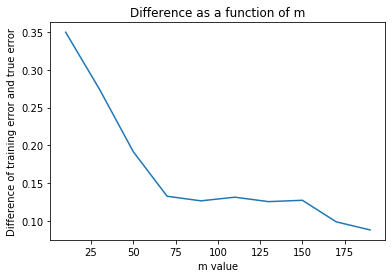

In [90]:
m, err_est_id3 = error_diff_estimation("id3")

#### 6. Design an alternative metric for splitting the data, not based on information content / information gain. Repeat the computation from (5) above for your metric, and compare the performance of your trees vs the ID3 trees

Alternative metric for splitting the data used below is Gini index, also known as Gini impurity. This finds the probability of a specific feature i.e., classified incorrectly when selected randomly.

In [93]:
def decision_tree_gini(data, features):
    tree = 0
    c0 = 0
    c1 = 0
    target = data.columns[-1]
    y_val = data[target].values.tolist()
    
    # Terminating conditions
    if len(data) == 0:
        return 0
    for i in y_val:
        if i == 0:
            c0 += 1
        else:
            c1 += 1
    if len(features) == 0:
        if c1 >= c0:
            return 1
        else:
            return 0
    if len(np.unique(y_val)) <= 1:
        return y_val[0]
    
    # finding the maximum gini value in the data
    gini_values = []

    for target in data.columns[:-1]:
        gini_index = 1 - (len(data[data[target] == 1]) / len(data)) ** 2 - (len(data[data[target] == 0]) / len(data)) ** 2
        gini_values.append(gini_index)

    max_gini = data.columns[gini_values.index(max(gini_values))] # maximum gini index value column is stored in max_gini
    if tree == 0:
        tree = {}
        tree[max_gini] = {}
    f = data.columns[:-1] # f is the features of the data
    f = [i for i in f if i != max_gini]
    # spliting the decision tree on the maximum gini index node for its value 0 and 1
    sub_tree = decision_tree_id3(data[data[max_gini] == 0], f)
    tree[max_gini][0] = sub_tree
    sub_tree = decision_tree_id3(data[data[max_gini] == 1], f)
    tree[max_gini][1] = sub_tree
    return tree

In [94]:
features = training_data.columns[:-1]
gi_tree = decision_tree_gini(training_data, features)
gi_tree

{'x4': {0: {'x1': {0: {'x2': {0: 1, 1: {'x3': {0: 1, 1: 0}}}}, 1: 0}},
  1: {'x1': {0: 0, 1: {'x3': {0: 0, 1: 1}}}}}}

Repeating the computation from (5) for Gini index

M value 10
M value 30
M value 50
M value 70
M value 90
M value 110
M value 130
M value 150
M value 170
M value 190


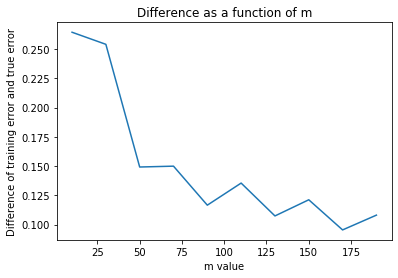

In [91]:
m, err_est_gi = error_diff_estimation("Gini")

Comparision between information gain and gini index metrics

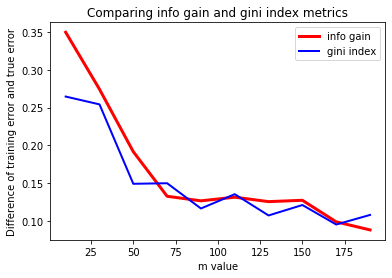

In [92]:
plt.plot(m, err_est_id3, marker='', color='red', linewidth=3, label="info gain")
plt.plot(m, err_est_gi, marker='', color='blue', linewidth=2, label="gini index")
plt.xlabel("m value")
plt.ylabel("Difference of training error and true error")
plt.title("Comparing info gain and gini index metrics")
plt.legend()
plt.show()

## Part 2: Pruning Decision Trees

#### 1. Write a function to generate m samples of (X,Y), and another to fit a tree to that data using ID3. Write a third function to, given a decision tree f, estimate the error rate of that decision tree on the underlying data, err(f). Do this repeatedly for a range of m values, and plot the ‘typical’ error of a tree trained on m data points as a function of m. Does this agree with your intuition?

generate_dataset(k,m) generates the dataset as per the given schema, also I have incorporated the recent changes in generate_dataset_shrink(k,m)
***
x0 as a fair coinflip, x1 through x10 each dependent on the previous as in the problem, and x11 through x15 as independent random variables - Y is either the majority of x1 through x5, or the majority of x6 through x10, depending on the value of x0.
***


In [ ]:
# Importing required libraries
from collections import Counter 

In [ ]:
def generate_dataset(k, m):
    # Generating X vector
    X = [[0 for i in range(k)] for i in range(m)]  # this creates an array of size m where each element is an array of size k with 0's.
    for i in range(m):
        X[i][0] = int(np.random.choice(a=2, size=1))
        # np.random.choice generates a random sample by choosing from np.arange(a) when a is an integer and
        # size is the size of the matrix generated by np.random.choice and
        # p is the probability of each choice in range(a).
        for j in range(1, k):
            if j <= 14:
                if np.random.choice(a=2, size=1, p=[0.25, 0.75]) == 1:
                    X[i][j] = X[i][j - 1]
                else:
                    X[i][j] = 1 - X[i][j - 1]
            else:
                X[i][j] = int(np.random.choice(a=2, size=1, p=[0.5, 0.5])) # Here we are converting it into int as np.random.choice returns an array

    # Calibrate Y values for each vector X
    y = []
    for i in range(m):
        if X[i][0] == 0:
            occ = Counter(X[i][1:8]) 
            y.append(max(occ, key=occ.get))
        elif X[i][0] == 1:
            occ = Counter(X[i][8:15]) 
            y.append(max(occ, key=occ.get))
    y = np.array([y]).T # transposing the Y values to append to X vector
    # final training data is X appended with Y
    data = pd.DataFrame(np.append(X, y, axis=1),columns=[str(i) for i in range(k)]+['Y'])
    return data

In [274]:
train_data = generate_dataset(21, 200)
train_data

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,Y
0,1,0,0,1,1,0,1,0,0,0,...,1,1,1,1,0,1,0,1,1,0
1,0,0,0,0,0,1,1,1,1,1,...,0,0,0,1,1,1,0,1,0,0
2,1,1,1,1,1,0,1,1,0,0,...,1,0,0,0,0,1,1,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,0,1,0,1,0,0
4,1,1,1,1,1,1,1,1,1,1,...,0,0,0,1,0,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,1,1,1,1,0,0,0,0,0,1,...,1,1,1,1,1,0,0,0,0,1
196,0,0,0,1,1,1,1,0,0,1,...,1,0,0,0,0,0,0,1,0,1
197,1,1,1,1,1,1,1,1,1,0,...,1,1,1,0,1,0,0,0,1,1
198,0,0,1,1,1,0,0,0,1,1,...,1,0,0,1,0,0,1,0,1,0


In [160]:
def generate_dataset_shrink(k, m):
    # Generating X vector
    X = [[0 for i in range(k)] for i in range(m)]  # this creates an array of size m where each element is an array of size k with 0's.
    for i in range(m):
        X[i][0] = int(np.random.choice(a=2, size=1))
        # np.random.choice generates a random sample by choosing from np.arange(a) when a is an integer and
        # size is the size of the matrix generated by np.random.choice and
        # p is the probability of each choice in range(a).
        for j in range(1, k):
            if j <= 11:
                if np.random.choice(a=2, size=1, p=[0.25, 0.75]) == 1:
                    X[i][j] = X[i][j - 1]
                else:
                    X[i][j] = 1 - X[i][j - 1]
            else:
                X[i][j] = int(np.random.choice(a=2, size=1, p=[0.5, 0.5])) # Here we are converting it into int as np.random.choice returns an array

    # Calibrate Y values for each vector X
    y = []
    for i in range(m):
        if X[i][0] == 0:
            occ = Counter(X[i][1:5]) 
            y.append(max(occ, key=occ.get))
        elif X[i][0] == 1:
            occ = Counter(X[i][5:10]) 
            y.append(max(occ, key=occ.get))
    y = np.array([y]).T # transposing the Y values to append to X vector
    # final training data is X appended with Y
    data = pd.DataFrame(np.append(X, y, axis=1),columns=[str(i) for i in range(k)]+['Y'])
    return data

In [161]:
train_data_shrink = generate_dataset_shrink(16,200)
train_data_shrink

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,Y
0,0,0,0,0,1,1,1,0,0,1,0,0,1,0,1,1,0
1,0,0,0,1,0,0,0,1,1,0,1,1,1,0,1,0,0
2,1,0,0,1,0,0,1,1,1,1,0,0,0,1,0,1,1
3,1,0,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1
4,1,1,1,1,1,1,1,1,1,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,1,1,1,1,1,1,1,0,0,1,1,1,1,1,0,1,1
196,0,0,0,1,1,1,0,1,1,1,0,0,0,0,0,1,0
197,0,0,0,0,0,1,1,1,1,1,1,1,0,0,0,1,0
198,1,1,1,1,1,1,1,0,0,0,0,0,0,0,1,0,0


For fitting the tree data in ID3 algorithm I'm re-using the function generated in the part-1 decision_tree_id3(training_data, features)

In [162]:
features = train_data.columns[:-1]
pd_tree = decision_tree_id3(train_data, features)
pd_tree

{'11': {0: {'6': {0: {'12': {0: 0,
      1: {'0': {0: 0, 1: {'15': {0: 0, 1: {'3': {0: 1, 1: 0}}}}}}}},
    1: {'0': {0: {'3': {0: {'14': {0: 1,
          1: {'4': {0: 0, 1: {'5': {0: 0, 1: 1}}}}}},
        1: 1}},
      1: {'8': {0: 0,
        1: {'13': {0: {'14': {0: 0, 1: {'9': {0: 0, 1: 1}}}}, 1: 1}}}}}}}},
  1: {'4': {0: {'0': {0: {'2': {0: 0,
        1: {'6': {0: 0, 1: {'7': {0: 0, 1: 1}}}}}},
      1: {'8': {0: {'14': {0: 0, 1: 1}}, 1: 1}}}},
    1: {'7': {0: {'19': {0: {'12': {0: 0,
          1: {'0': {0: {'2': {0: {'6': {0: 0, 1: 1}}, 1: 1}},
            1: {'1': {0: 1, 1: 0}}}}}},
        1: {'3': {0: {'0': {0: 0, 1: 1}}, 1: 1}}}},
      1: {'8': {0: {'1': {0: 0, 1: 1}}, 1: 1}}}}}}}}

For estimating the error rate of that decision tree on the underlying data, err(f) I'm using the previously written error(data, tree) function.

Yes, the below plot agrees with my intuition as there is a marginal decrease in error values with the increase in m values

In [163]:
def typical_error_pd(k, m, tree):
    te = 0
    for i in range(0,100):
        data = generate_dataset(k,m)
        te += error(data,tree)
    te = te/100
    return te

def error_varied_m(k):
    error = [] # initializing error value list as null
    # Storing multiple values of m to find the difference of training error and true error in mval
    mval = list(range(10, 2000, 100)) 
    for m in mval:
        print("M value", m) # To verify what all m values are there and is there a corresponding point in the plot.
        data = generate_dataset(k, m)       
        features = data.columns[:-1]
        tree = decision_tree_id3(data, features)
        error.append(typical_error_pd(k, m, tree))
    #Plotting a graph of error difference as a function of m
    plt.plot(mval, error)
    plt.xlabel("m value")
    plt.ylabel("Typical error")
    plt.title("Typical error as a function of m")
    plt.show()
    return mval, error

M value 10
M value 110
M value 210
M value 310
M value 410
M value 510
M value 610
M value 710
M value 810
M value 910
M value 1010
M value 1110
M value 1210
M value 1310
M value 1410
M value 1510
M value 1610
M value 1710
M value 1810
M value 1910


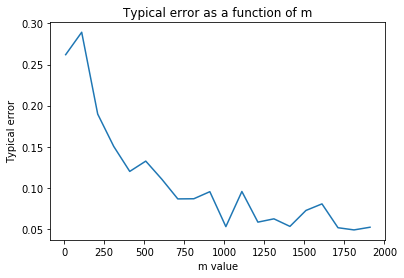

In [146]:
m, typical_error = error_varied_m(k)

#### 2. Note that $X_{15}$ through $X_{20}$ are completely irrelevant to predicting the value of Y . For a range of m values, repeatedly generate data sets of that size and fit trees to that data, and estimate the average number of irrelevant variables that are included in the fit tree. How much data would you need, typically, to avoid fitting on this noise?

In [276]:
def tree_variables(data, tree, tree_vars = []):
    for i in tree.keys():
        tree_vars.append(i)
        val0 = tree[i][0]
        if type(val0) is dict:
            tree_variables(data, val0)
        val1 = tree[i][1]
        if type(val1) is dict:
            tree_variables(data, val1)
        else:
            break
    return tree_vars


def irrelevant_variables(k):
    m = [100, 1000, 5000, 10000, 20000]
    irr_count = []
    for i in range(len(m)):
        count = []
        for j in range(3):
            c = 0
            data = generate_dataset(k, m[i])       
            features = data.columns[:-1]
            tree = decision_tree_id3(data, features)
            tree_vars = tree_variables(data, tree)
            for l in range(0, len(tree_vars)): 
                tree_vars[l] = int(tree_vars[l])
                if tree_vars[l] > 14:
                    c += 1
            tree_vars.clear()
            count.append(c)
        irr_count.append(sum(count)/len(count))
        print(irr_count[i])
    plt.plot(m, irr_count)
    plt.xlabel("m value")
    plt.ylabel("Average no. of irrelevant variables")
    plt.title("Irrelevant variables as a function of m")
    plt.show()

1.6666666666666667
5.666666666666667
6.333333333333333
7.0
0.6666666666666666


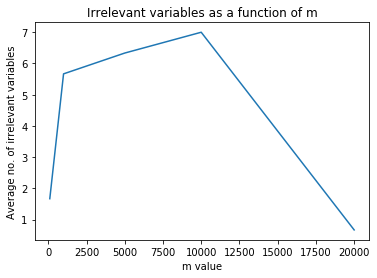

In [277]:
irrelevant_variables(21)

 It can be inferred from the graph, that we need more than 10000 data points for irrelevant features to be of less noise. 
 
#### 3. Generate a data set of size m = 10000, and set aside 8000 points for training, and 2000 points for testing. The remaining questions should all be applied to this data set.

a. Pruning by Depth
Consider growing a tree as a process - running ID3 for instance until all splits up to depth d have been performed. Depth d = 0 should correspond to no decisions - a prediction for Y is made just on the raw frequencies of Y in the data. Plot, as a function of d, the error on the training set and the error on the test set for a tree grown to depth d. What does your data suggest as a good threshold depth?

In [176]:
data_q3 = generate_dataset(21, 10000)
train_q3, test_q3 = data_q3[:8000].reset_index(drop = True), data_q3[8000:].reset_index(drop = True)

In [180]:
def decision_tree_depth(data, features, dep, d):
    info_gain = []
    tree = 0
    c0 = 0
    c1 = 0
    target = data.columns[-1]
    y_val = data[target].values.tolist() #moving the target values to y_val

    # Terminating conditions for decision tree
    
    if len(data) == 0:
        return 0
    for i in y_val:
        if i == 0:
            c0 += 1
        else:
            c1 += 1
    if len(features) == 0:
        if c1 >= c0:
            return 1
        else:
            return 0
    if len(np.unique(y_val)) <= 1:
        return y_val[0]
    
    for col in data.columns[:-1]:
        info_gain.append(entropy(data) - conditional_entropy(data, col))


    max_info_gain = data.columns[info_gain.index(max(info_gain))] # finding the maximum information gain feature of the data 
    
    if tree == 0:
        tree = {}
        tree[max_info_gain] = {}

    f = data.columns[:-1] # f is the features of the data
    f = [i for i in f if i != max_info_gain]
    # spliting the decision tree on the maximum info gain node for its value 0 and 1
    
    if d < dep:
        d += 1
        sub_tree = decision_tree_depth(data[data[max_info_gain] == 0], f, dep, d)
        tree[max_info_gain][0] = sub_tree
        sub_tree = decision_tree_depth(data[data[max_info_gain] == 1], f, dep, d)
        tree[max_info_gain][1] = sub_tree
    else:
        if c1 >= c0:
            tree[max_info_gain][0] = 1
            tree[max_info_gain][1] = 1
        else:
            tree[max_info_gain][0] = 0
            tree[max_info_gain][1] = 0    
    return tree



In [183]:
def pruning_depth_err(data_q3):
    train_q3, test_q3 = data_q3[:8000].reset_index(drop = True), data_q3[8000:].reset_index(drop = True)
    depth = list(range(1, 11))
    training_error = []
    testing_error = []
    features = train_q3.columns[:-1]
    for i in range(0,10):
        tree = decision_tree_depth(train_q3, features, depth[i], 0)
        tr_err = error(train_q3,tree)
        training_error.append(tr_err)
        t_err = error(test_q3, tree)
        testing_error.append(t_err)
        print("At depth ",depth[i], " error in training data: ", tr_err," and error in testing data: ", t_err)
    plt.plot(depth, training_error, marker='', color='green', linewidth=3, label="Training error")
    plt.plot(depth, testing_error, marker='', color='red', linewidth=2, label="Testing error")
    plt.xlabel("Depth")
    plt.ylabel("Errors")
    plt.title("Pruning by Depth")
    plt.legend()
    plt.show()

At depth  1  error in training data:  0.33275  and error in testing data:  0.3365
At depth  2  error in training data:  0.3105  and error in testing data:  0.312
At depth  3  error in training data:  0.185125  and error in testing data:  0.184
At depth  4  error in training data:  0.157375  and error in testing data:  0.1635
At depth  5  error in training data:  0.093375  and error in testing data:  0.0965
At depth  6  error in training data:  0.0685  and error in testing data:  0.0835
At depth  7  error in training data:  0.0415  and error in testing data:  0.058
At depth  8  error in training data:  0.019625  and error in testing data:  0.029
At depth  9  error in training data:  0.006875  and error in testing data:  0.015
At depth  10  error in training data:  0.002125  and error in testing data:  0.015


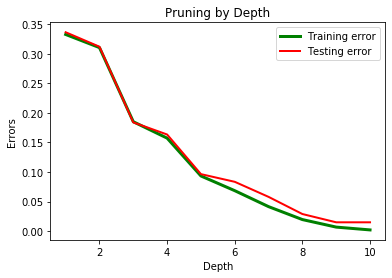

In [184]:
pruning_depth_err(data_q3)

Based on the above output we can conclude that a good threshold depth is around the range 6-9. After a depth of 9, the training error drops to 0, but test error is there. 

#### b. Pruning by Sample Size:
#### The less data a split is performed on, the less ‘accurate’ we expect the result of that split to be. Let s be a threshold such that if the data available at a node in your decision tree is less than or equal to s, you do not split and instead decide Y by simple majority vote (ties broken by coin flip). Plot, as a function of s, the error on the training set and the error on the testing set for a tree split down to sample size s. What does your data suggest as a good sample size threshold?

In [201]:
def decision_tree_sample_size(data, features, sample_size):
    info_gain = []
    tree = 0
    c0 = 0
    c1 = 0
    target = data.columns[-1]
    y_val = data[target].values.tolist() #moving the target values to y_val

    # Terminating conditions for decision tree
    
    if len(data) == 0:
        return 0
    for i in y_val:
        if i == 0:
            c0 += 1
        else:
            c1 += 1
    if len(features) == 0:
        if c1 >= c0:
            return 1
        else:
            return 0
    if len(np.unique(y_val)) <= 1:
        return y_val[0]
    
    for col in data.columns[:-1]:
        info_gain.append(entropy(data) - conditional_entropy(data, col))


    max_info_gain = data.columns[info_gain.index(max(info_gain))] # finding the maximum information gain feature of the data 
    
    if tree == 0:
        tree = {}
        tree[max_info_gain] = {}

    f = data.columns[:-1] # f is the features of the data
    f = [i for i in f if i != max_info_gain]
    # spliting the decision tree on the maximum info gain node for its value 0 and 1

    if len(data) >= sample_size:
        sub_tree = decision_tree_sample_size(data[data[max_info_gain] == 0],features, sample_size)
        tree[max_info_gain][0] = sub_tree
        sub_tree = decision_tree_sample_size(data[data[max_info_gain] == 1],features, sample_size)
        tree[max_info_gain][1] = sub_tree
    else:
        if c1 >= c0:
            tree[max_info_gain][0] = 1
            tree[max_info_gain][1] = 1
        else:
            tree[max_info_gain][0] = 0
            tree[max_info_gain][1] = 0        
    return tree

def pruning_samplesize_err(data_q3):
    train_q3 = data_q3.iloc[:8000, :]
    test_q3 = data_q3.iloc[8000:, :]
    sample_size = list(range(10, 250, 10))
    training_error = []
    testing_error = []
    features = training_data.columns[:-1]
    for i in range(0,24):
        tree = decision_tree_sample_size(train_q3, features, sample_size[i])
        tr_err = error(train_q3,tree)
        training_error.append(tr_err)
        t_err = error(test_q3, tree)
        testing_error.append(t_err)
        print("For sample size ",sample_size[i], " error in training data: ", tr_err," and error in testing data: ", t_err)
    plt.plot(sample_size, training_error, marker='', color='green', linewidth=3, label="Training error")
    plt.plot(sample_size, testing_error, marker='', color='red', linewidth=2, label="Testing error")
    plt.xlabel("Sample size")
    plt.ylabel("Errors")
    plt.title("Pruning by sample size")
    plt.legend()
    plt.show()

For sample size  10  error in training data:  0.012625  and error in testing data:  0.0235
For sample size  20  error in training data:  0.02475  and error in testing data:  0.039
For sample size  30  error in training data:  0.032625  and error in testing data:  0.0425
For sample size  40  error in training data:  0.0425  and error in testing data:  0.0525
For sample size  50  error in training data:  0.04725  and error in testing data:  0.0645
For sample size  60  error in training data:  0.058375  and error in testing data:  0.0735
For sample size  70  error in training data:  0.060625  and error in testing data:  0.076
For sample size  80  error in training data:  0.062875  and error in testing data:  0.076
For sample size  90  error in training data:  0.067375  and error in testing data:  0.084
For sample size  100  error in training data:  0.072  and error in testing data:  0.088
For sample size  110  error in training data:  0.072125  and error in testing data:  0.0885
For sampl

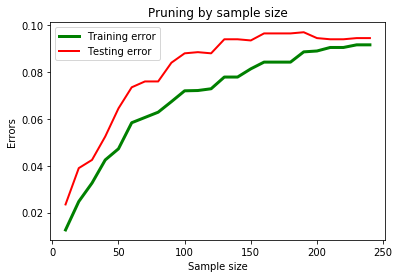

In [202]:
pruning_samplesize_err(data_q3)

Based on the above output we can conclude as the minimum sample size increases, training and testing error increases.

For the above graph around sample size 50 to 100 can be considered as a good threshold.

#### 5. Repeat the computation of Problem 2, growing your trees only to depth d as chosen in 3.a. How does this change the likelihood or frequency of including spurious variables in your trees?



In [269]:
def irrelevant_variables_with_depth(d):
    m = [100, 1000, 5000, 10000, 15000]
    irr_count = []
    count = []
    for i in range(len(m)):
        count.clear()
        for j in range(3):
            c = 0
            data = generate_dataset(21, m[i])       
            features = data.columns[:-1]
            tree = decision_tree_depth(data, features, d, 0)
            tree_vars = tree_variables(data, tree)
            for l in range(0, len(tree_vars)): 
                tree_vars[l] = int(tree_vars[l])
                if tree_vars[l] > 14:
                    c += 1
            count.append(c)
            tree_vars.clear()
        avg = sum(count)/len(count) 
        irr_count.append(avg)
    plt.plot(m, irr_count)
    plt.xlabel("m value")
    plt.ylabel("No. of irrelevant variables")
    plt.title("Irrelevant variables as a function of m")
    plt.show()

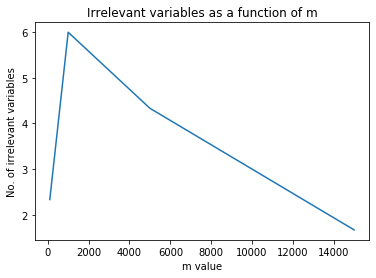

In [270]:
irrelevant_variables_with_depth(8)

Number of irrelevant variables present in the model of the tree reduce as m value increases, thereby we can infer that pruning the tree w.r.t. depth is beneficial in removing noise. 

#### 6. Repeat the computation of Problem 2, splitting your trees only to sample size s as chosen in 3.b. How does this change the likelihood or frequency of including spurious variables in your trees?

In [272]:
def irrelevant_variables_with_sample_size(s):
    m = [100, 500, 1000, 5000, 10000, 20000]
    irr_count = []
    for i in range(len(m)):
        count = []
        for j in range(4):
            c = 0
            data = generate_dataset(21, m[i])       
            features = data.columns[:-1]
            tree = decision_tree_sample_size(data, features,s)
            tree_vars = tree_variables(data, tree)
            for l in range(0, len(tree_vars)): 
                tree_vars[l] = int(tree_vars[l])
                if tree_vars[l] > 14:
                    c += 1
            count.append(c)
            tree_vars.clear()
        irr_count.append(sum(count)/len(count))
    plt.plot(m, irr_count)
    plt.xlabel("m value")
    plt.ylabel("No. of irrelevant variables ")
    plt.title("Irrelevant variables as a function of m")
    plt.show()

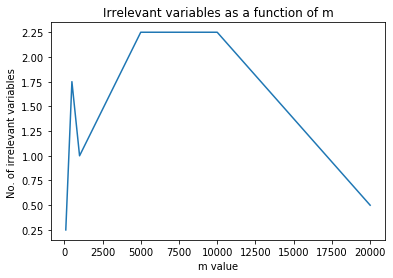

In [273]:
irrelevant_variables_with_sample_size(50)

We can see that no. of irrelevant variables decreases with increase in m value (sample size). So, we can say that pruning with sample size aids in removing noise. Also, after 10,000 there is a steady and steep decrease in average no.of irrelevant variables as it might not represent the actual data if m value is low.